In [1]:
#Import libraries
import pandas as pd
import numpy as np
import random
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#use a fixed seed to ensure the same results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#Load processed dataset
df = pd.read_csv("../data/processed/clean_dataset_full.csv")
df.head()


,clean_symptoms,Age,Gender,Symptom_Count,label
0,fever back pain short breath,29,Male,3,0
1,insomnia back pain weight loss,76,Female,3,27
2,sore throat vomit diarrhea,78,Male,3,19
3,blur vision depress weight loss muscl pain,58,Other,4,26
4,swell appetit loss nausea,55,Female,3,16


In [4]:
#Encode gender as a numerical feature
df['Gender_encoded'] = df['Gender'].map({'Male':0, 'Female':1, 'Other':2})
df[['Gender', 'Gender_encoded']].head()


,Gender,Gender_encoded
0,Male,0
1,Female,1
2,Male,0
3,Other,2
4,Female,1


In [5]:
#TF-IDF Vectorization of Symptom Text
tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2)
)

X_text_tfidf = tfidf.fit_transform(df['clean_symptoms'])
X_text_tfidf.shape


(25000, 647)

In [6]:
#Combine Text and Numeric Features
X_numeric = df[['Age', 'Symptom_Count', 'Gender_encoded']].values

X = sparse.hstack([
    X_text_tfidf,
    sparse.csr_matrix(X_numeric)
])

X.shape


(25000, 650)

In [7]:
#Defining the target variable
y = df['label'].values

In [8]:
#Train, Test Split, fixed seed

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)

In [9]:
#Train Logistic Regression Model
clf = LogisticRegression(
    max_iter=4000,
    solver='saga',
    multi_class='multinomial',
    class_weight='balanced',
     random_state=SEED,
    n_jobs=-1
)

clf.fit(X_train, y_train)

C:\Users\rahom\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'saga'
,max_iter,4000
,multi_class,'multinomial'


In [10]:
#Evaluation Metrics
y_pred = clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.029866666666666666

 Classification Report:

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       128
           1       0.03      0.04      0.03       122
           2       0.03      0.03      0.03       137
           3       0.04      0.04      0.04       135
           4       0.02      0.03      0.02       118
           5       0.04      0.04      0.04       128
           6       0.02      0.02      0.02       126
           7       0.03      0.03      0.03       121
           8       0.01      0.01      0.01       121
           9       0.03      0.03      0.03       123
          10       0.05      0.04      0.04       129
          11       0.03      0.02      0.02       129
          12       0.02      0.02      0.02       127
          13       0.04      0.05      0.04       125
          14       0.03      0.03      0.03       131
          15       0.06      0.06      0.06       121
          16       

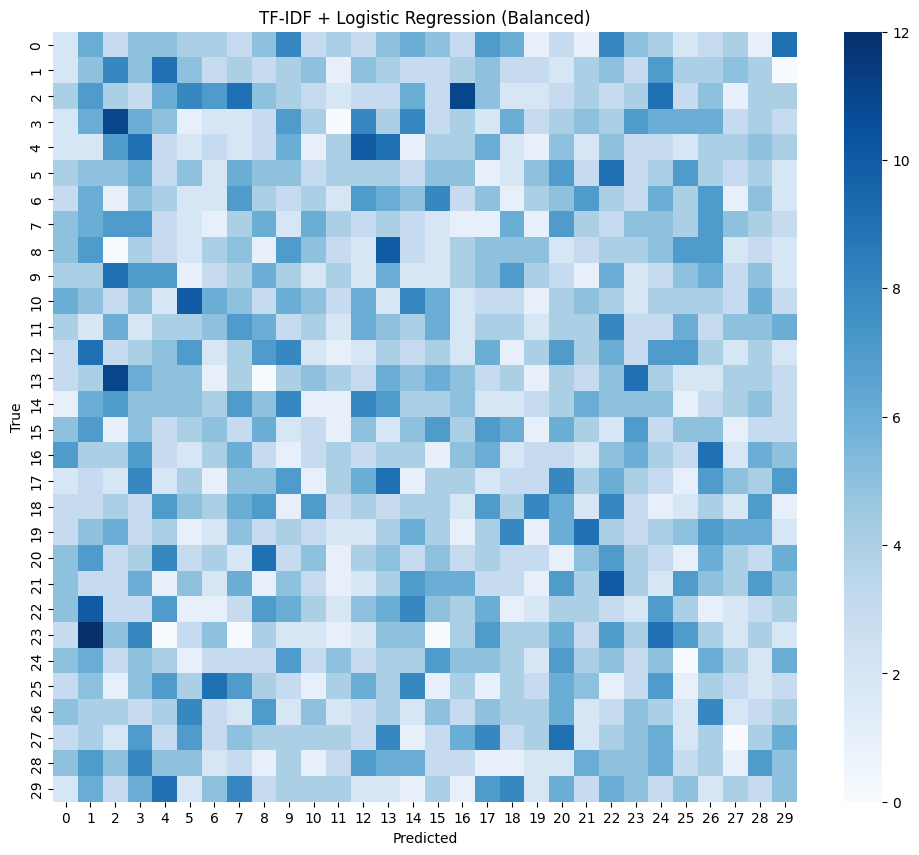

In [11]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TF-IDF + Logistic Regression (Balanced)")
plt.show()


In [12]:
#Save Model and Vectorizer for Deployment
import joblib

joblib.dump(clf, "../data/processed/tfidf_logreg_model.pkl")

joblib.dump(tfidf, "../data/processed/tfidf_vectorizer.pkl")


['../data/processed/tfidf_vectorizer.pkl']